# Implementación con Random Forest /Decisión Forest

Carlos Patricio Castaneda Bustamante 

Maestria en ingenieria en computacion / Universidad Autonoma de Chihuahua

## Librerias

In [87]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


## Preprocesamiento y separacion de datos

In [88]:
df = pd.read_csv('/Volumes/Maestria/GitHub/NEO/NEO/nearest-earth-objects(1910-2024).csv')

df.drop(columns=['neo_id', 'orbiting_body', 'name'], inplace=True)
le = LabelEncoder()
df['is_hazardous'] = le.fit_transform(df['is_hazardous'])
df = df.dropna()
df_test = df.copy()
sm = SMOTE(sampling_strategy='minority', random_state=42)
oversampled_X, oversampled_Y = sm.fit_resample(df_test.drop('is_hazardous', axis=1), df_test['is_hazardous'])
df = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

df_target = df['is_hazardous']
df_target_array = df_target.values
df_features = df.drop(columns=['is_hazardous'])
df_features_array = df_features.values

preprocess = ColumnTransformer([
    ('scaler', StandardScaler(), ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance'])
])

pipeline = Pipeline([
    ('preprocess', preprocess)])

df_preprocessed = pipeline.fit_transform(df)
df_preprocessed


X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(df_preprocessed, df_target_array, test_size=0.2)

X_train, X_test, y_train, y_test = train_test_split(df_features_array, df_target_array, test_size=0.2, random_state=42)







<Axes: >

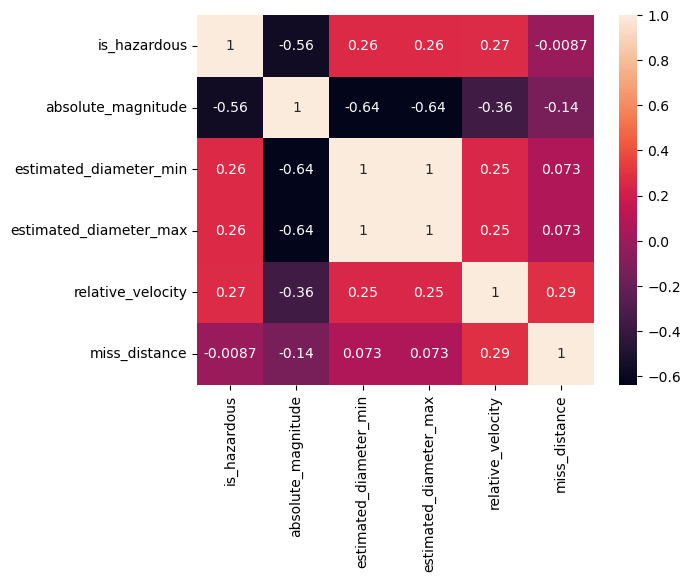

In [89]:
sns.heatmap(df.corr(), annot=True)

In [90]:
corr_matrix = df.corr()

corr_matrix['is_hazardous'].sort_values(ascending=False)

is_hazardous              1.000000
relative_velocity         0.266009
estimated_diameter_min    0.263725
estimated_diameter_max    0.263725
miss_distance            -0.008683
absolute_magnitude       -0.564632
Name: is_hazardous, dtype: float64

## Random Forest

Se declara un modelo de random forest con unos parametros ya definidos

In [91]:
randomf = RandomForestClassifier(n_estimators=100, random_state=42, warm_start=True, class_weight='balanced_subsample')
randomf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': True}

Por el tamaño de la base de datos, se selecciona un sample de 100k para probar los modelos

Primero, se prueba el random forest con la base de datos estandarizada haciendo un gridsearch para encontrar los mejores parametros

In [92]:
indices = np.random.choice(X_train_std.shape[0], 100000, replace=False)  

X_train_sample_std = X_train_std[indices]
y_train_sample_std = y_train_std[indices]


param_grid = { 'criterion': ['gini', 'entropy'],
                'max_features': ['auto', 'sqrt', 'log2'], 
                'bootstrap': [True, False],
                         
}

grid_search = GridSearchCV(randomf, param_grid, cv=5)
grid_search.fit(X_train_sample_std, y_train_sample_std)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')
print(f'Best Estimator: {grid_search.best_estimator_} ')

best_randomf_std = grid_search.best_estimator_

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:862: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:862: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights

Best parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'sqrt'}
Best Score: 0.9252
Best Estimator: RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       random_state=42, warm_start=True) 


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:862: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:468: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


Accuracy: 0.9275363546998406
Recall: 0.9334539368015284
F1 score: 0.9281265497213653
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.92      0.93     58857
           1       0.92      0.93      0.93     59147

    accuracy                           0.93    118004
   macro avg       0.93      0.93      0.93    118004
weighted avg       0.93      0.93      0.93    118004



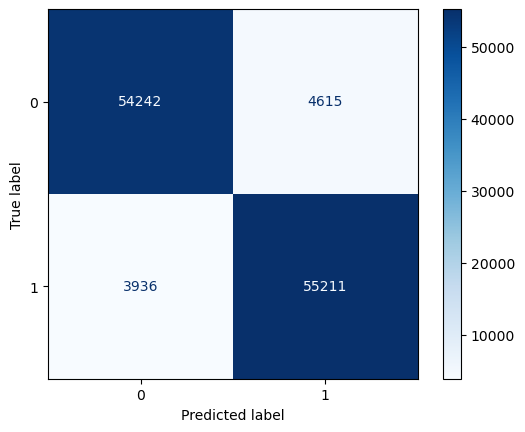

<Axes: >

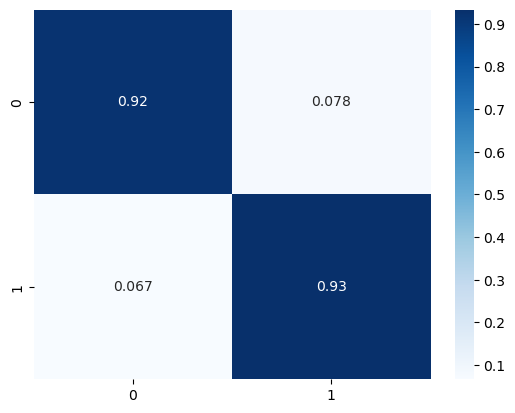

In [93]:


best_randomf_std.fit(X_train_sample_std, y_train_sample_std)

predictions = best_randomf_std.predict(X_test_std)

accuracy = accuracy_score(y_test_std, predictions)
recall = recall_score(y_test_std, predictions)
f1 = f1_score(y_test_std, predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")


print(f'Classification Report: \n {classification_report(y_test_std, predictions)}')

cm = confusion_matrix(y_test_std, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

cm2 = cm / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm2, annot=True, cmap='Blues')


Se vuelve a hacer un gridsearch con las base de datos sin estandarizar

In [94]:
indices = np.random.choice(X_train.shape[0], 100000, replace=False)  

X_train_sample = X_train[indices]
y_train_sample = y_train[indices]


param_grid = { 'criterion': ['gini', 'entropy'],
                'max_features': ['auto', 'sqrt', 'log2'], 
                'bootstrap': [True, False],
                         
}

grid_search = GridSearchCV(randomf, param_grid, cv=5)
grid_search.fit(X_train_sample, y_train_sample)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')
print(f'Best Estimator: {grid_search.best_estimator_} ')

best_randomf = grid_search.best_estimator_

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:862: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:862: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights

Best parameters: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt'}
Best Score: 0.92311
Best Estimator: RandomForestClassifier(class_weight='balanced_subsample', random_state=42,
                       warm_start=True) 


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:862: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:468: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


Accuracy: 0.9315446934002237
Recall: 0.933586595210637
F1 score: 0.9316431702404928
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93     59040
           1       0.93      0.93      0.93     58964

    accuracy                           0.93    118004
   macro avg       0.93      0.93      0.93    118004
weighted avg       0.93      0.93      0.93    118004



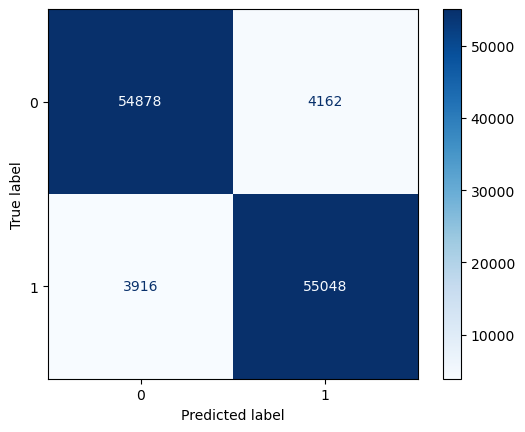

<Axes: >

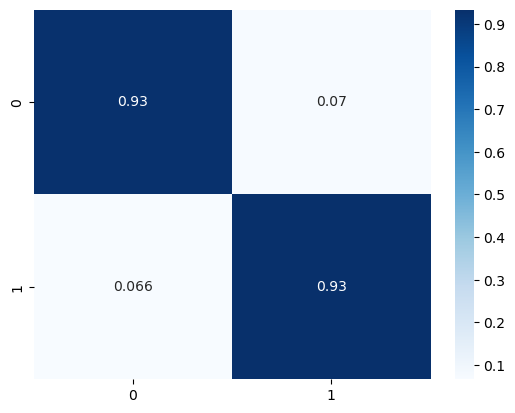

In [95]:


best_randomf.fit(X_train_sample, y_train_sample)

predictions = best_randomf.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")


print(f'Classification Report: \n {classification_report(y_test, predictions)}')


cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

cm2 = cm / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm2, annot=True, cmap='Blues')



## Decision Tree

Se declara un modelo de decision tree con unos parametros predefinidos

In [96]:
decisiontree = DecisionTreeClassifier(random_state=42,class_weight='balanced')

Se utiliza un gridsearch para encontrar los mejores parametros primero con los valores estandarizados de la base de datos

In [97]:
indices = np.random.choice(X_train_std.shape[0], 100000, replace=False)  

X_train_sample_std = X_train_std[indices]
y_train_sample_std = y_train_std[indices]


param_grid = { 'criterion': ['gini', 'entropy'],
                'max_features': ['auto', 'sqrt', 'log2'], 
                'splitter': ['best', 'random']
                         
}

grid_search = GridSearchCV(decisiontree, param_grid, cv=5)
grid_search.fit(X_train_sample_std, y_train_sample_std)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')
print(f'Best Estimator: {grid_search.best_estimator_} ')

best_tree_std = grid_search.best_estimator_

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pack

Best parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'best'}
Best Score: 0.8918199999999998
Best Estimator: DecisionTreeClassifier(class_weight='balanced', max_features='sqrt',
                       random_state=42) 


Accuracy: 0.9020372190773194
Recall: 0.8923360440935297
F1 score: 0.9012961286907222
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.91      0.90     58857
           1       0.91      0.89      0.90     59147

    accuracy                           0.90    118004
   macro avg       0.90      0.90      0.90    118004
weighted avg       0.90      0.90      0.90    118004



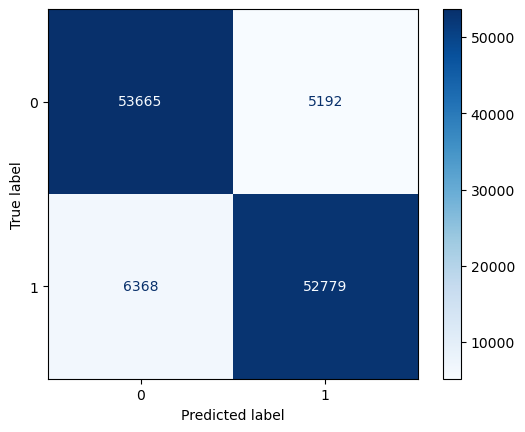

<Axes: >

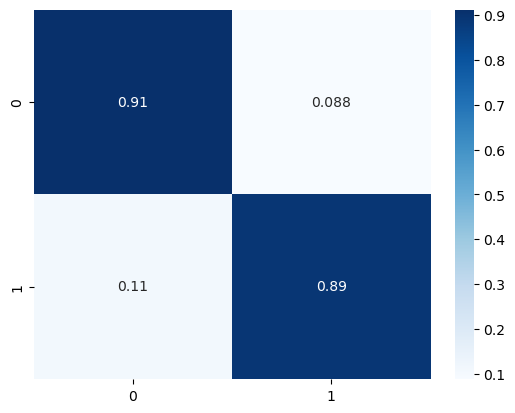

In [98]:


best_tree_std.fit(X_train_sample_std, y_train_sample_std)

predictions = best_tree_std.predict(X_test_std)

accuracy = accuracy_score(y_test_std, predictions)
recall = recall_score(y_test_std, predictions)
f1 = f1_score(y_test_std, predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")


print(f'Classification Report: \n {classification_report(y_test_std, predictions)}')

cm = confusion_matrix(y_test_std, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

cm2 = cm / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm2, annot=True, cmap='Blues')

In [99]:
indices = np.random.choice(X_train.shape[0], 100000, replace=False)  

X_train_sample = X_train[indices]
y_train_sample = y_train[indices]


param_grid = { 'criterion': ['gini', 'entropy'],
                'max_features': ['auto', 'sqrt', 'log2'], 
                'splitter': ['best', 'random']
                         
}

grid_search = GridSearchCV(decisiontree, param_grid, cv=5)
grid_search.fit(X_train_sample, y_train_sample)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')
print(f'Best Estimator: {grid_search.best_estimator_} ')

best_tree = grid_search.best_estimator_

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pack

Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}
Best Score: 0.89914
Best Estimator: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_features='sqrt', random_state=42) 


Accuracy: 0.9130707433646317
Recall: 0.9066040295773693
F1 score: 0.9124534871812379
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.92      0.91     59040
           1       0.92      0.91      0.91     58964

    accuracy                           0.91    118004
   macro avg       0.91      0.91      0.91    118004
weighted avg       0.91      0.91      0.91    118004



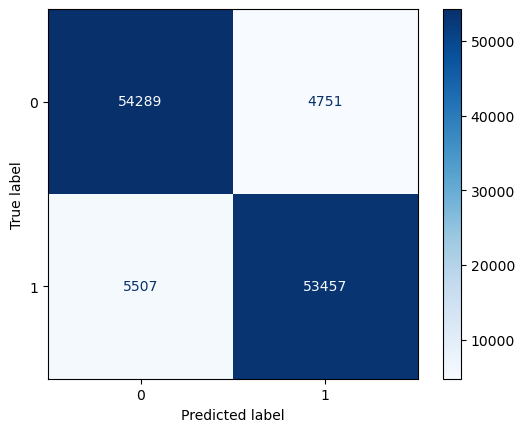

<Axes: >

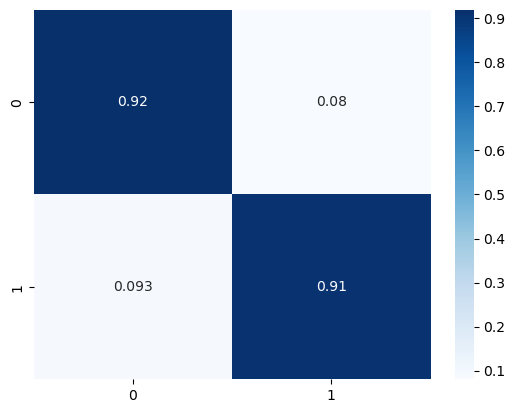

In [100]:


best_tree.fit(X_train_sample, y_train_sample)

predictions = best_tree.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")


print(f'Classification Report: \n {classification_report(y_test, predictions)}')


cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

cm2 = cm / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm2, annot=True, cmap='Blues')

# Conclusiones

## Random Forest

Para entrenar el random forest, se separaron 2 sets de entrenamiento, uno estandarizado y otro sin estandarizar, para probar la diferencia de los resultados, aunque en realidad, no se apreció diferencia alguna, siendo el resultado para los datos std de un promedio de 92.5% mientras para los no std del 92.3%

Random forest regresa una clasificacion del 93% para [0] y 93% para [1]

Random Forest a mostrado los mejores resultados hasta este punto, a comparacion de Regresion Logistica, SVM con sus 3 kernels y el Decision Tree

## Decision Tree

En el caso de decision tree, la estandarizacion de los datos si afectó el resultado, ya que un decision tree con los datos std arrojaba un promedio del 90% mientras que para los datos no std regresó 91%


Para los datos std regresa una clasificacion del 91% para [0] y 89% para [1]

Mientras que para los datos no std regresa un 92% para [0] y 91% para [1]